In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import os.path as path
import matplotlib.ticker as ticker
from scipy.integrate import simps, trapz

import matplotlib as mpl
mpl.rcParams.update({
    'font.family' : 'STIXGeneral',
    'mathtext.fontset' : 'stix',
    'xtick.direction' : 'in' ,
    'xtick.labelsize' : 13 ,
    'xtick.top' : True ,
    'ytick.direction' : 'in' ,
    'ytick.labelsize' : 13 ,
    'ytick.right' : True ,
    'axes.labelsize' : 16,
    'legend.frameon' : False,
    'legend.fontsize' : 13,
    'legend.handlelength' : 1.5,
    'savefig.dpi' : 600, 
    'savefig.bbox' : 'tight'
})

In [2]:
!pwd

/home/hyejin/Desktop/my_git/DMFT_NN/2_nn


In [3]:
D = 1
out_node = 2
directory = '../1_dmftsolver/NRG'

w, A,Gr,Gi,_,_,_,_,_,_ = np.loadtxt(f'{directory}/B_41_beta10000/Bethe-{2.25:.3f}.dat', \
                       unpack = True, dtype = 'complex128')

plt.plot(w.real, np.arange(len(w)))
plt.xlabel(r'real frequency $\omega$')
plt.ylabel('cumulant number')
plt.axhspan(1319-500, 1319+500, alpha=0.5, color='#ffee52')
plt.annotate(r'$\omega\simeq0$', xy=(0.4, 0.475), xycoords = 'axes fraction', fontsize=15, ha='center')

plt.show()

number, bins, patches = plt.hist(w.real, bins=2001)
plt.xlabel(r'real frequency $\omega$')
plt.ylabel('index number')


OSError: ../1_dmftsolver/NRG/B_41_beta10000/Bethe-2.250.dat not found.

# Data

### ED data

In [10]:
def EDbath(e, V):
    return np.array([np.sum(V**2/(1j*omega[i]-e)) for i in range (aa)])

beta = 100
directory1 = '../1_dmftsolver/ED'
a = np.loadtxt(f'{directory1}/ED_14_beta{beta:d}/checkpoint-{3.00:.2f}', dtype = 'float64')
iw, Giwr, Giwi = np.loadtxt(f'{directory1}/ED_14_beta{beta:d}/Giw-{3.00:.2f}.dat',\
                                       unpack = True, dtype = 'float64')
e, V = a[:5], a[5:]

aa = 10000
omega = np.pi/beta * (2*np.arange(aa)+1)

In [12]:
beta = 100
directory1 = '../1_dmftsolver/ED'
up_num = 211
dn_num = 211
U = np.array([0.01*i for i in range(50, 501)])
U1_ed = np.zeros(up_num, dtype = 'float64')
U2_ed = np.zeros(dn_num, dtype = 'float64')
U_c1_ed, U_c2_ed = 2.4, 2.93


n = 0
for i, u in enumerate(U):
    if path.isfile(f'{directory1}/ED_14_beta{beta:d}/checkpoint-{u:.2f}')==False: continue
    U1_ed[n] = u
    n += 1
n = 0
for i, u in enumerate(U):
    if path.isfile(f'{directory1}/ED_41_beta{beta:d}/checkpoint-{u:.2f}')==False: continue
    U2_ed[n] = u
    n += 1

x_test_ed = np.zeros((len(U1_ed)+len(U2_ed), 10000), dtype = 'float64')
UU1 = U1_ed[U1_ed<2.0]
UU2 = U2_ed[U2_ed>3.0]
x = np.zeros((len(UU1)+len(UU2), 10000), dtype = 'float64')

for i,u in enumerate(U1_ed):
    a = np.loadtxt(f'{directory1}/ED_14_beta{beta:d}/checkpoint-{u:.2f}', dtype = 'float64')
    e,V = a[:int(len(a)/2)], a[int(len(a)/2):]
    x_test_ed[i][:aa] = EDbath(e,V).imag
for i,u in enumerate(U2_ed):
    a = np.loadtxt(f'{directory1}/ED_41_beta{beta:d}/checkpoint-{u:.2f}', dtype = 'float64')
    e,V = a[:int(len(a)/2)], a[int(len(a)/2):]
    x_test_ed[i+len(U1_ed)][:aa] = EDbath(e,V).imag
    
for i,u in enumerate(UU1):
    a = np.loadtxt(f'{directory1}/ED_14_beta{beta:d}/checkpoint-{u:.2f}', dtype = 'float64')
    e,V = a[:int(len(a)/2)], a[int(len(a)/2):]
    x[i][:aa] = EDbath(e,V).imag
for i,u in enumerate(UU2):
    a = np.loadtxt(f'{directory1}/ED_41_beta{beta:d}/checkpoint-{u:.2f}', dtype = 'float64')
    e,V = a[:int(len(a)/2)], a[int(len(a)/2):]
    x[i+len(UU1)][:aa] = EDbath(e,V).imag
    
x_test_ed = -torch.FloatTensor(x_test_ed)
x = -torch.FloatTensor(x)

y_temp1 = np.array(U1_ed < U_c2_ed)
y_temp2 = np.array(U2_ed < U_c1_ed)
y_temp = np.concatenate([y_temp1, y_temp2])
y_test_ed = np.stack([y_temp, ~y_temp], axis = 1)
y_test_ed = torch.FloatTensor(y_test_ed)

y_temp1 = np.array(UU1 < U_c2_ed)
y_temp2 = np.array(UU2 < U_c1_ed)
y_temp = np.concatenate([y_temp1, y_temp2])
y = np.stack([y_temp, ~y_temp], axis = 1)
y = torch.FloatTensor(y)
UU_ed = np.concatenate((U1_ed, U2_ed))

def divide(x_, y_):
    mask = np.random.rand(len(x_)) < 0.9  # train : val = 4 : 1
    x_train, x_val = x_[mask], x_[~mask]
    y_train, y_val = y_[mask], y_[~mask]
    return x_train, x_val, y_train, y_val
x_train, x_val, y_train, y_val = divide(x, y)

In [13]:
size = len(x[0])
class Net(nn.Module):
    def __init__(self, node = None, activate = None):
        super(Net, self).__init__()
        self.node = node
        self.W1 = nn.Linear(size, self.node)#, bias=False)
        self.b1 = nn.Linear(self.node, 1, bias=False)
        self.W2 = nn.Linear(self.node, out_node)#, bias=False)
        self.b2 = nn.Linear(out_node, 1, bias=False)
        self.activate = activate()
        self.sig = nn.Sigmoid()

        #self.W1.weight.data.fill_(0)
        nn.init.uniform_(self.W1.weight, -0.001, 0.001)
        nn.init.xavier_normal_(self.W2.weight)
        self.b1.weight.data.fill_(0)
        self.b2.weight.data.fill_(0)
        '''
        if (activate==nn.Sigmoid or activate==nn.Tanh):
            nn.init.xavier_normal_(self.W1.weight)
            nn.init.xavier_normal_(self.W2.weight)
        else:
            nn.init.kaiming_normal_(self.W1.weight)
            nn.init.kaiming_normal_(self.W2.weight)
        '''

    def forward(self, x):
        x = self.activate(self.W1(x)+self.b1.weight.data)
        x = self.W2(x)+self.b2.weight.data
        return self.sig(x)

    def loss1(self, output, y, reg): # regularization l1
        regular = reg*(torch.norm(self.W1.weight.data, p=1)+torch.norm(self.W2.weight.data, p=1))
        return F.binary_cross_entropy(output, y) + regular # cross entropy loss
    def loss2(self, output, y, reg): # regularization l2
        regular = reg*(torch.norm(self.W1.weight.data)**2+torch.norm(self.W2.weight.data)**2)
        return F.binary_cross_entropy(output, y) + regular # cross entropy loss

    def accuracy(self, output, y):
        return np.average((output>=0.5)==y)

In [18]:
learning_rate = 1e-2
reg = 1e-4
func = nn.Sigmoid
out_node = 2
h_node = 100
#model = Net(node = h_node, activate = func)
optimizer = optim.SGD(model.parameters(), lr = learning_rate)
n_epochs = 20000
train_loss, val_loss, test_acc = np.ones(n_epochs+1), np.ones(n_epochs+1), np.ones(n_epochs+1)
for epoch in range (n_epochs+1):
    loss = model.loss1(model.forward(x_train), y_train, reg)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    valid_loss = model.loss1(model.forward(x_val), y_val, reg).item()
    t_acc = model.accuracy(model.forward(x_test_ed), y_test_ed)
    train_loss[epoch], val_loss[epoch], test_acc[epoch] = loss.item(), valid_loss, t_acc

    if epoch%int(n_epochs/10) == 0:
        print('epoch = %d, training loss = %.6f, valid loss = %.6f, accuracy = %.8f' \
                %(epoch, loss.item(), valid_loss, t_acc))

epoch = 0, training loss = 0.645382, valid loss = 0.644036, accuracy = 0.92417062
epoch = 2000, training loss = 0.437191, valid loss = 0.432805, accuracy = 0.93601896
epoch = 4000, training loss = 0.255044, valid loss = 0.250322, accuracy = 0.93838863
epoch = 6000, training loss = 0.174901, valid loss = 0.171299, accuracy = 0.94075829
epoch = 8000, training loss = 0.141949, valid loss = 0.139262, accuracy = 0.94075829
epoch = 10000, training loss = 0.126561, valid loss = 0.124482, accuracy = 0.94312796


KeyboardInterrupt: 

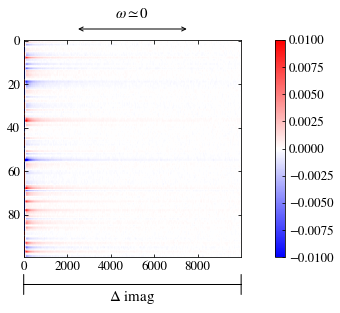

In [19]:
fig, ax = plt.subplots(1, 1, figsize = (12, 4))
op = {'vmin': -0.01, 'vmax': 0.01}
OP = {'vmin': -1.5, 'vmax': 1.5}
im1 = ax.imshow(np.array(model.W1.weight.data), aspect=10000/100, cmap='bwr', **op)
#im2 = ax[1].imshow(Weight*number, aspect=2000/h_node, cmap='bwr', **OP)
import matplotlib.ticker as ticker
#ax[1].xaxis.set_major_locator(ticker.MultipleLocator(500))
#ax[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: r'%.1f'%((x-1000)/200)))
#ax[1].set_xlabel(r'$\omega$')
ax.annotate('', xy=(0, -0.125), xytext=(1, -0.125), xycoords='axes fraction',\
               ha='center', va="center", arrowprops={'arrowstyle':'|-|', 'shrinkA':0, 'shrinkB':0})

ax.annotate('', xy=(0.25, 1.05), xytext=(0.75, 1.05), xycoords='axes fraction',\
               ha='center', va="center", arrowprops={'arrowstyle':'<->', 'shrinkA':0, 'shrinkB':0})
ax.annotate(r'$\omega\simeq0$', xy=(0.5, 1.1), xycoords = 'axes fraction', fontsize=15, ha='center')
ax.annotate(r'$\Delta$ imag', xy=(0.5, -0.2), xycoords = 'axes fraction', fontsize=15, ha='center')

cd = plt.colorbar(im1, ax=ax)
#cd = plt.colorbar(im2, ax=ax[1])
#plt.savefig('NN_Weight_u0.001_10.png')
plt.show()

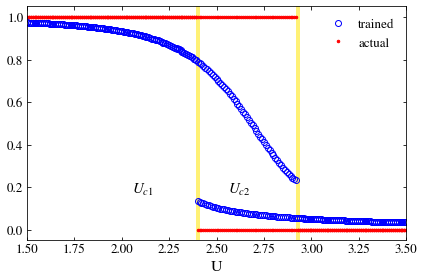

In [22]:
plt.axvline(U_c1_ed, c = '#ffee52', lw = '4',  alpha=0.8)
plt.axvline(U_c2_ed, c = '#ffee52', lw = '4',  alpha=0.8)
plt.plot(UU_ed, model.forward(x_test_ed).data[:,0], 'bo', mfc='none', label = 'trained')
#plt.plot(UU_ed, x_test_ed[:,0]/torch.max(x_test_ed[:, 0]), 'g^', ms=6, mfc='none', label=r'$Im\Delta(\omega=0)$')
#plt.plot(UU_ed, np.average(x_test_ed[:,0:150], axis=1)/np.max(np.average(x_test_ed[:,0:150], axis=1)), 'g^', ms=6, mfc='none', label=r'$Im\Delta(\omega=0)$')
plt.plot(UU_ed, y_test_ed[:,0], 'r.', ms = 5, label = 'actual')
plt.xlim(1.5, 3.5)
plt.xlabel('U')
plt.annotate(r'$U_{c1}$', xy=(0.305, 0.2), xycoords = 'axes fraction', fontsize=15, ha='center')
plt.annotate(r'$U_{c2}$', xy=(0.56, 0.2), xycoords = 'axes fraction', fontsize=15, ha='center')
#plt.title(r'$\beta=100$', fontsize=16)
plt.legend()

plt.tight_layout(w_pad=1.5)
#plt.savefig('LogisticRegression_outputcubic_u0.001.png')

## Saving result

In [38]:
model.W1.weight.data.shape, model.W2.weight.data.shape

(torch.Size([100, 10000]), torch.Size([2, 100]))

In [80]:
torch.save(model.W1.weight.data, 'frozen_mat/iw_NN100_W1.pt')
torch.save(model.W2.weight.data, 'frozen_mat/iw_NN100_W2.pt')
torch.save(model.b1.weight.data, 'frozen_mat/iw_NN100_b1.pt')
torch.save(model.b2.weight.data, 'frozen_mat/iw_NN100_b2.pt')

In [85]:
model.W1(torch.ones(10000))

tensor([ 0.4195, -0.9049,  0.8431, -0.0445, -0.7510, -0.7479,  0.8529,  0.8971,
         0.7434,  1.0910,  0.2069,  0.5765, -0.5259,  0.2681, -1.1487, -0.9524,
        -1.0809, -0.8065, -0.0622, -0.7618,  0.3829,  0.8541,  1.0798, -0.9763,
        -0.9821, -0.4679,  1.0614,  0.1158, -0.8669,  0.9203,  1.1054,  0.9830,
        -1.1095,  0.7968, -0.1612,  0.9340, -0.0402,  1.5542, -0.6566, -0.8957,
         0.1385, -0.6714,  0.0450,  0.3044,  0.1771, -1.0810,  0.9254,  0.7480,
         0.8577, -0.6188,  0.1721, -0.8725,  0.9769,  0.2498,  0.6788, -3.4423,
        -0.6988, -1.0370, -0.9456, -0.6134,  0.8273,  1.0059,  0.6985,  0.5595,
         0.5783,  0.8478,  0.9607, -0.6886,  1.6248,  0.2372, -0.7907, -0.8960,
         0.5114, -0.5664,  0.5726, -0.8330, -0.8301, -0.7113,  0.9095, -0.9682,
        -0.9286, -0.9932,  0.9774, -0.8052, -0.3468, -0.2278, -0.8094, -0.9977,
         0.2849,  0.5261, -0.1151,  0.9682,  0.3173,  0.2412, -0.9534,  0.3034,
         0.9452,  0.6649, -0.4453,  0.76

In [89]:
net = Net(node = h_node, activate = func)
torch.save(model.state_dict(), 'iNN100model.pth')
net.load_state_dict(torch.load('iNN100model.pth'))

<All keys matched successfully>